# Курсовой проект

**Выполнил:** Логинов Пётр Константинович\
**Год:** 2024\
**Группа:** ИД22-4

Ссылка на исходный датасет:
https://www.kaggle.com/datasets/ihelon/coffee-sales

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")
import datetime

In [ ]:
df = pd.read_csv('index.csv')
df.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [ ]:
df['cash_type'].unique()

array(['card', 'cash'], dtype=object)

In [ ]:
df['coffee_name'].unique()

array(['Latte', 'Hot Chocolate', 'Americano', 'Americano with Milk',
       'Cocoa', 'Cortado', 'Espresso', 'Cappuccino'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2341 non-null   object 
 1   datetime     2341 non-null   object 
 2   cash_type    2341 non-null   object 
 3   card         2252 non-null   object 
 4   money        2341 non-null   float64
 5   coffee_name  2341 non-null   object 
dtypes: float64(1), object(5)
memory usage: 109.9+ KB


In [ ]:
df.describe()

,money
count,2341.000000
mean,31.816736
std,5.094530
min,18.120000
25%,27.920000
50%,32.820000
75%,35.760000
max,40.000000


In [ ]:
df.isnull().sum()

,0
date,0
datetime,0
cash_type,0
card,89
money,0
coffee_name,0


## Визуализация данных

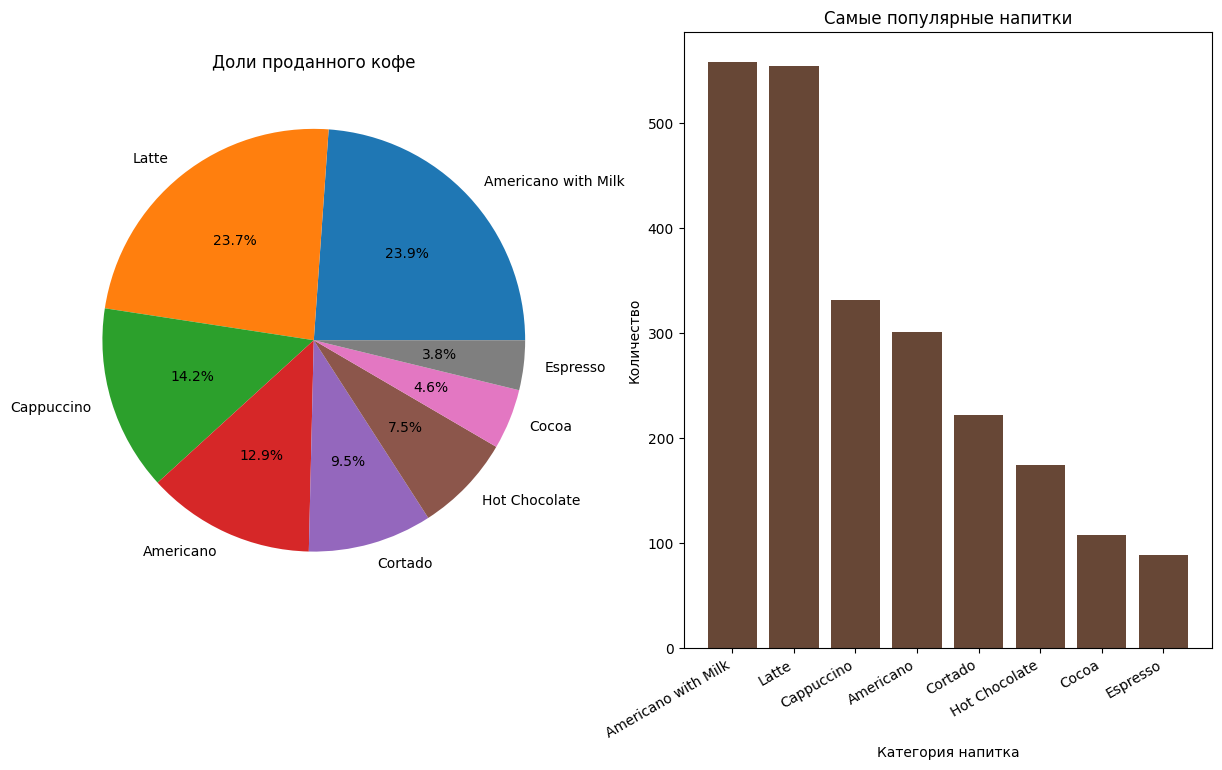

In [ ]:
counts=pd.DataFrame(df['coffee_name'].value_counts())
counts=counts.reset_index()

figure, axis = plt.subplots(1, 2, figsize=(15,8))

axis[0].pie(counts['count'], autopct='%1.1f%%', labels=counts['coffee_name'])
axis[0].set_title('Доли проданного кофе')

axis[1].bar(counts['coffee_name'], counts['count'], color='#674736')
axis[1].set_title('Самые популярные напитки')
axis[1].set_xlabel('Категория напитка')
axis[1].set_ylabel('Количество')

for label in axis[1].get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')

plt.show()

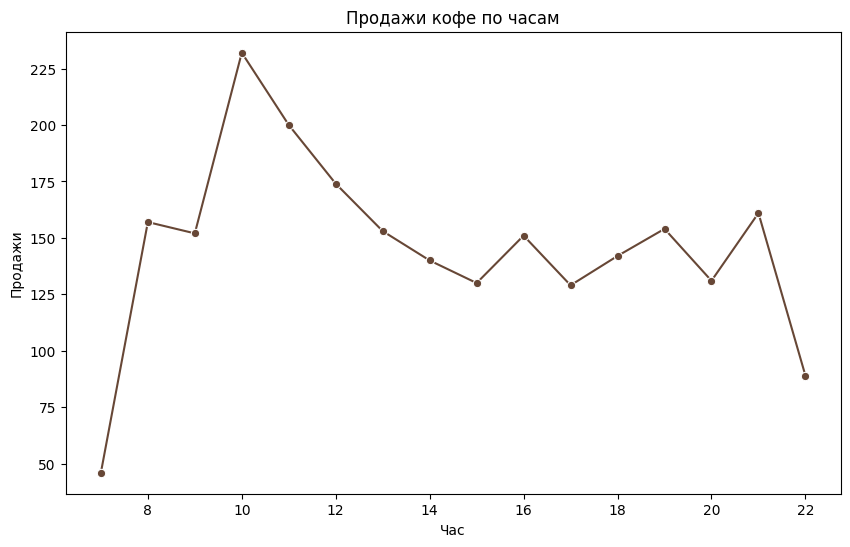

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
hour = df['datetime'].dt.hour
counts=hour.value_counts()
counts.reset_index()


plt.figure(figsize=(10, 6))
sns.lineplot(counts, color='#674736', marker='o')
plt.xlabel('Час')
plt.ylabel('Продажи')
plt.title('Продажи кофе по часам')
plt.show()

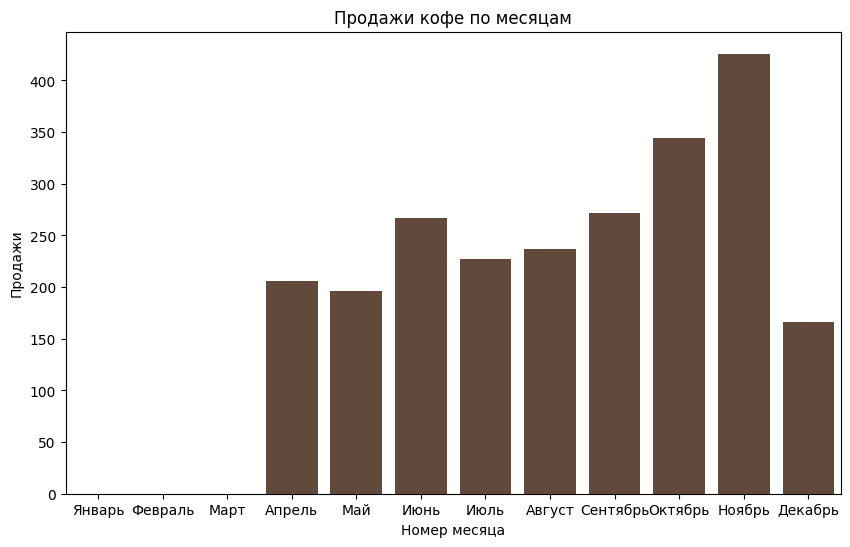

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
month = df['datetime'].dt.month
counts=month.value_counts()
counts = counts.reset_index()

month_names = ['Январь', 'Февраль',
    'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'
]
counts['month_name'] = counts['datetime'].map(lambda x: month_names[x])


plt.figure(figsize=(10, 6))
sns.barplot(counts, x='month_name', y='count', order = month_names, color='#674736')
plt.xlabel('Номер месяца')
plt.ylabel('Продажи')
plt.title('Продажи кофе по месяцам')
plt.show()

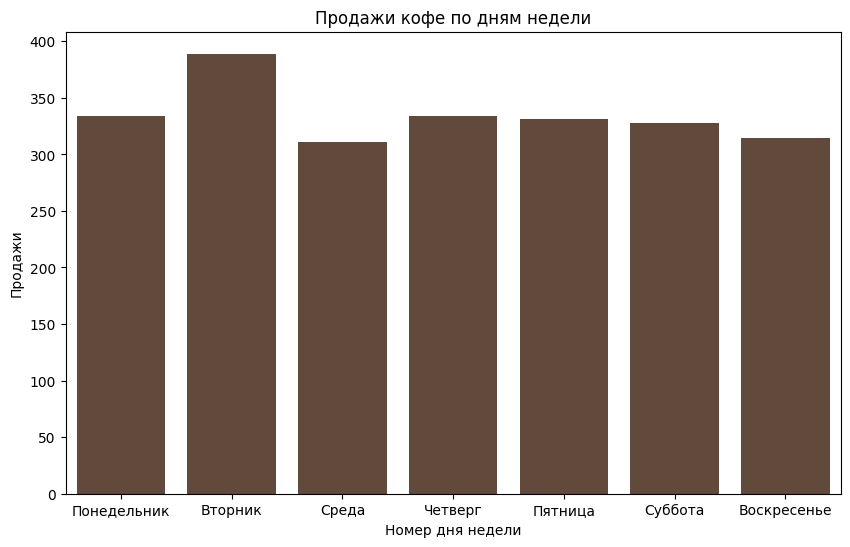

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])
weekday = df['datetime'].dt.weekday
counts=weekday.value_counts()
counts = counts.reset_index()

day_names = [
    'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'
]

counts['day_name'] = counts['datetime'].map(lambda x: day_names[x])

plt.figure(figsize=(10, 6))
sns.barplot(counts, x='day_name', y='count', color='#674736', order = day_names)
plt.xlabel('Номер дня недели')
plt.ylabel('Продажи')
plt.title('Продажи кофе по дням недели')
plt.show()

## Предобработка данных

In [ ]:
df_new = pd.DataFrame(df.copy())
df_new.head()

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


In [ ]:
df_new = df_new.groupby('date').agg(sales=('coffee_name', 'count')).reset_index()
df_new

,date,sales
0,2024-03-01,11
1,2024-03-02,7
2,2024-03-03,10
3,2024-03-04,4
4,2024-03-05,9
...,...,...
253,2024-11-12,9
254,2024-11-13,6
255,2024-11-14,14
256,2024-11-15,11


In [ ]:
df_new['date'] = pd.to_datetime(df_new['date'])
df_new

,date,sales
0,2024-03-01,11
1,2024-03-02,7
2,2024-03-03,10
3,2024-03-04,4
4,2024-03-05,9
...,...,...
253,2024-11-12,9
254,2024-11-13,6
255,2024-11-14,14
256,2024-11-15,11


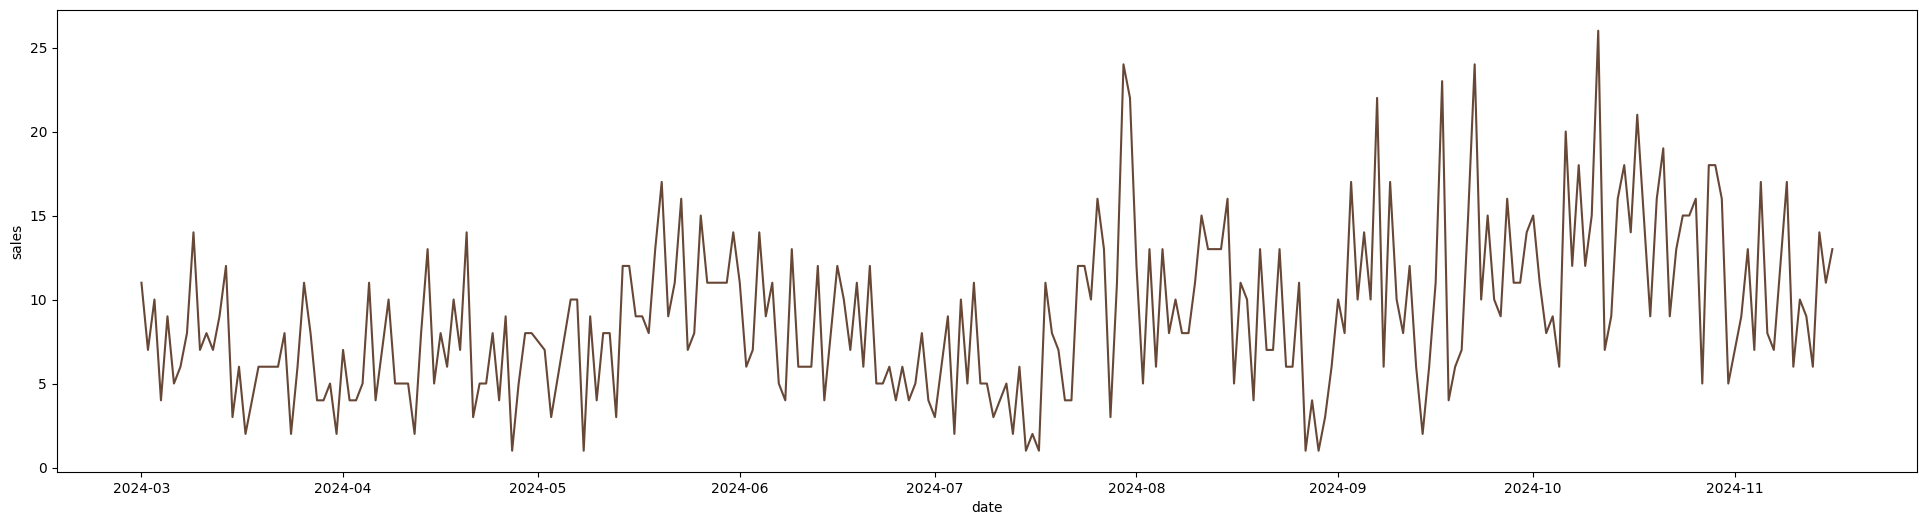

In [ ]:
plt.figure(figsize=(24, 6))
sns.lineplot(df_new, x='date', y='sales', color='#674736')
plt.show()

<Axes: >

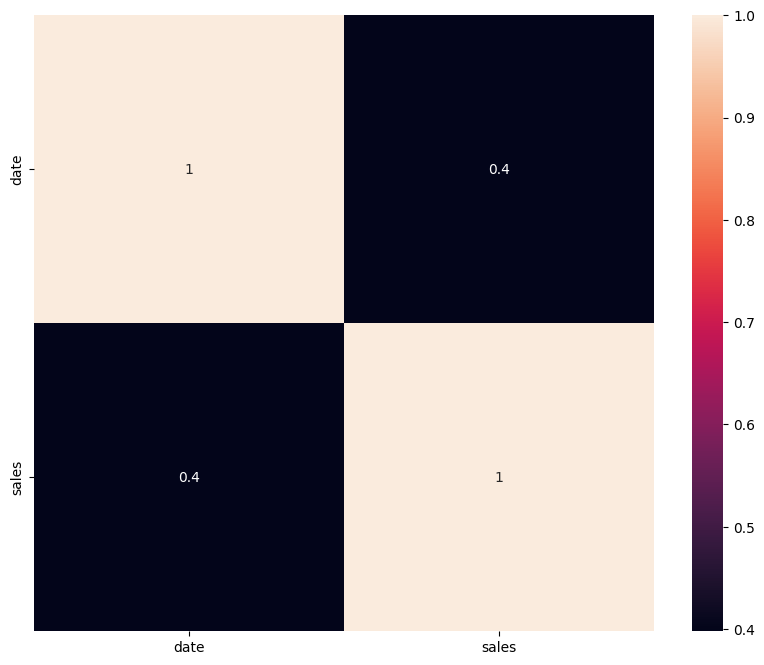

In [ ]:
corr = df_new.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True)

In [ ]:
df_new.describe()

,date,sales
count,258,258.000000
mean,2024-07-09 18:36:16.744186112,9.073643
min,2024-03-01 00:00:00,1.000000
25%,2024-05-07 06:00:00,6.000000
50%,2024-07-10 12:00:00,8.000000
75%,2024-09-12 18:00:00,12.000000
max,2024-11-16 00:00:00,26.000000
std,NaN,4.793641


Проверка датасета

In [ ]:
result = adfuller(df_new['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.049099638953868
p-value: 0.030556626568113997


## Обучение моделей

### Линейная регрессия

In [ ]:
X = pd.DataFrame(df_new.index)
y = df_new['sales']
X

,0
0,0
1,1
2,2
3,3
4,4
...,...
253,253
254,254
255,255
256,256


In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

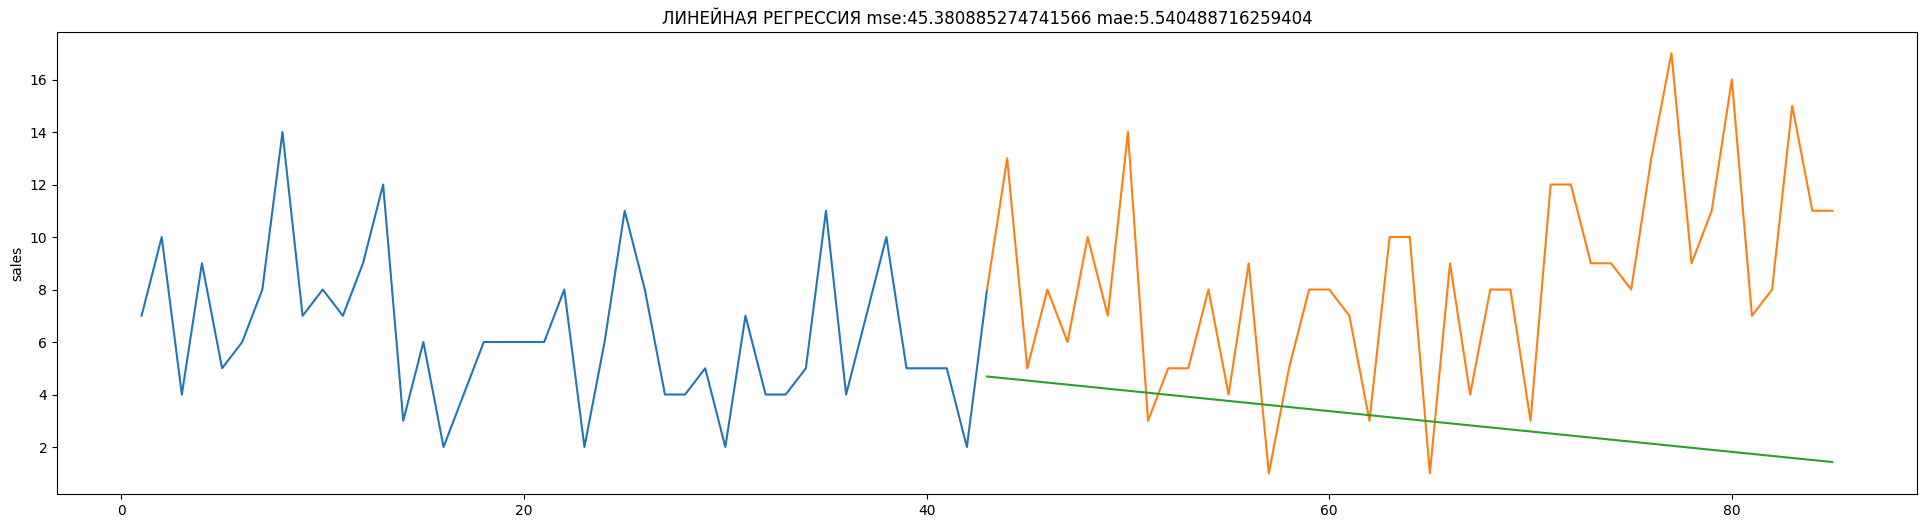

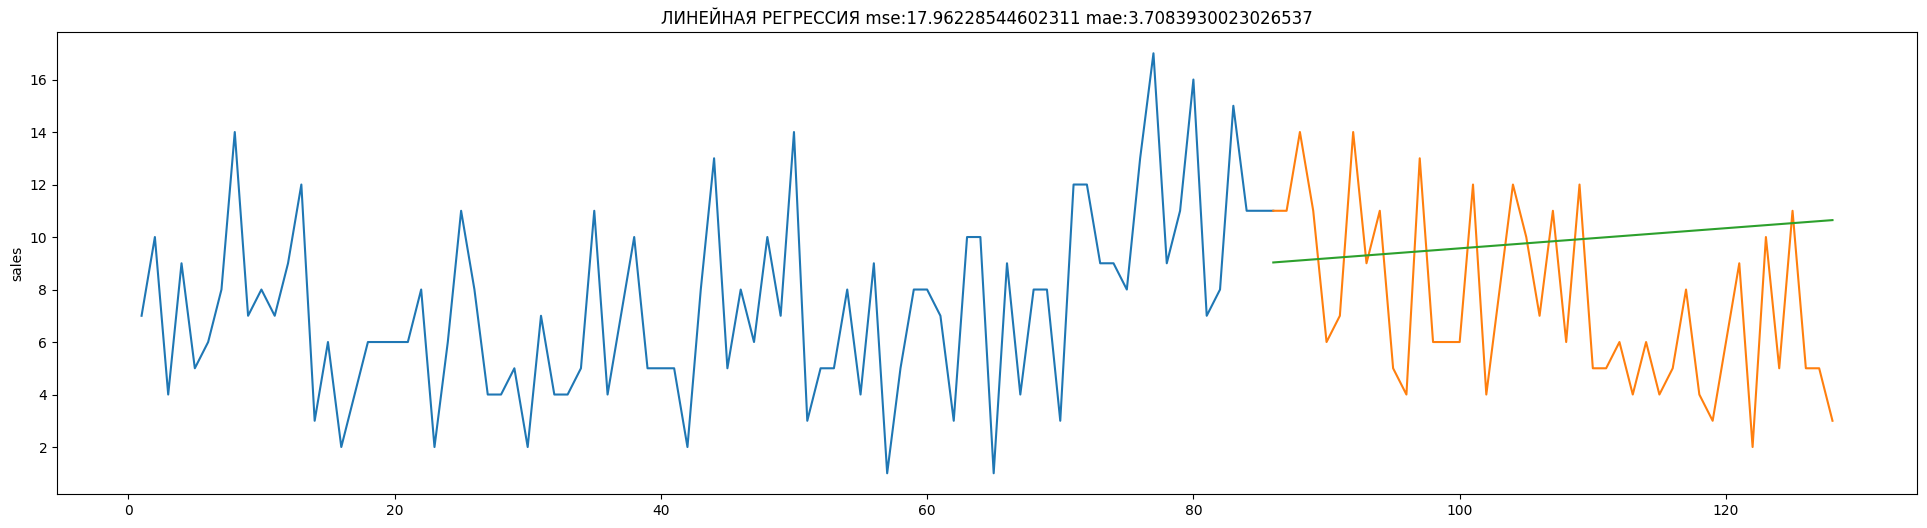

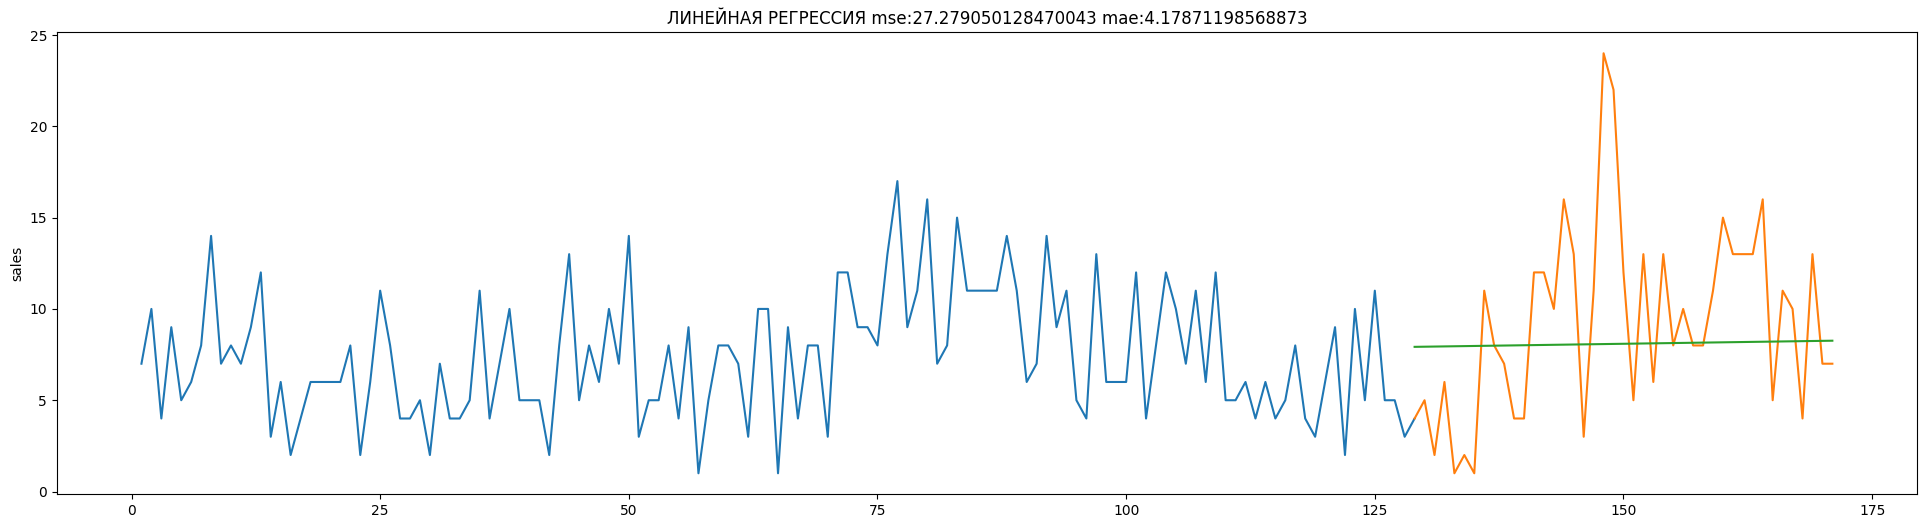

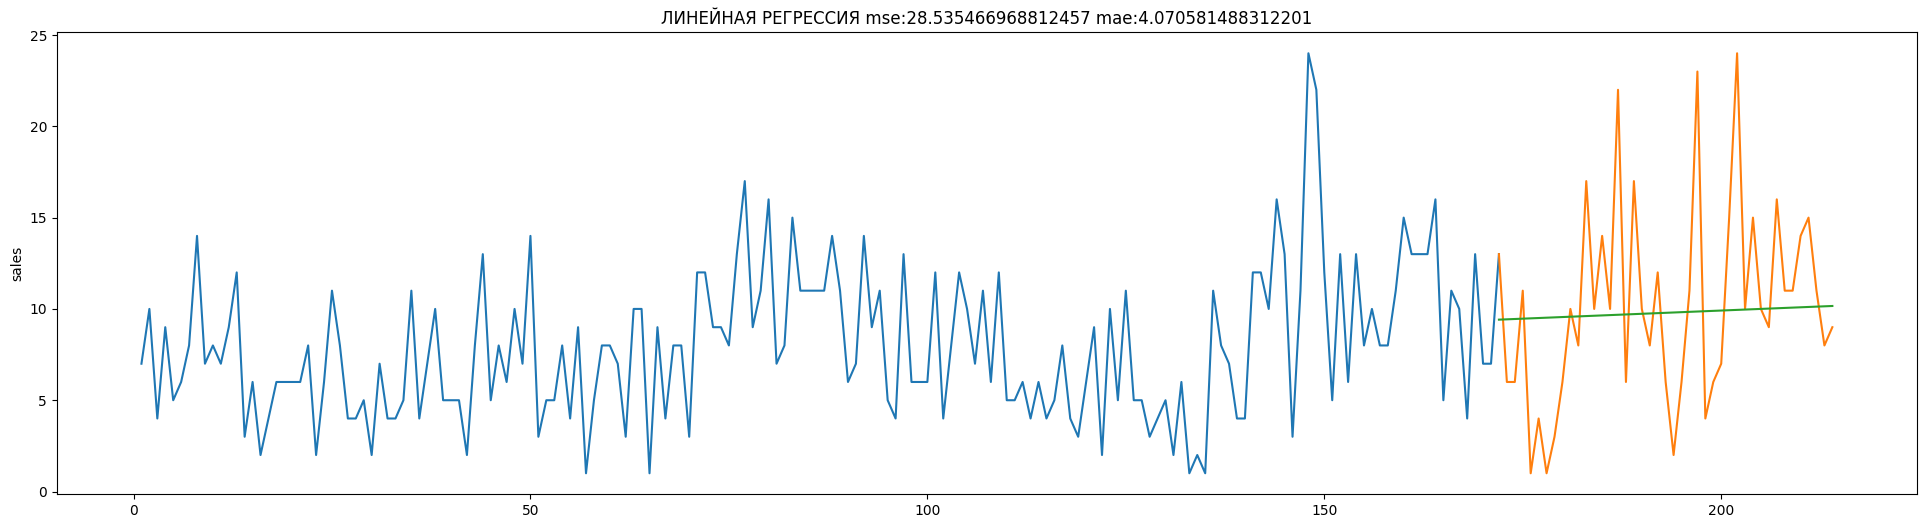

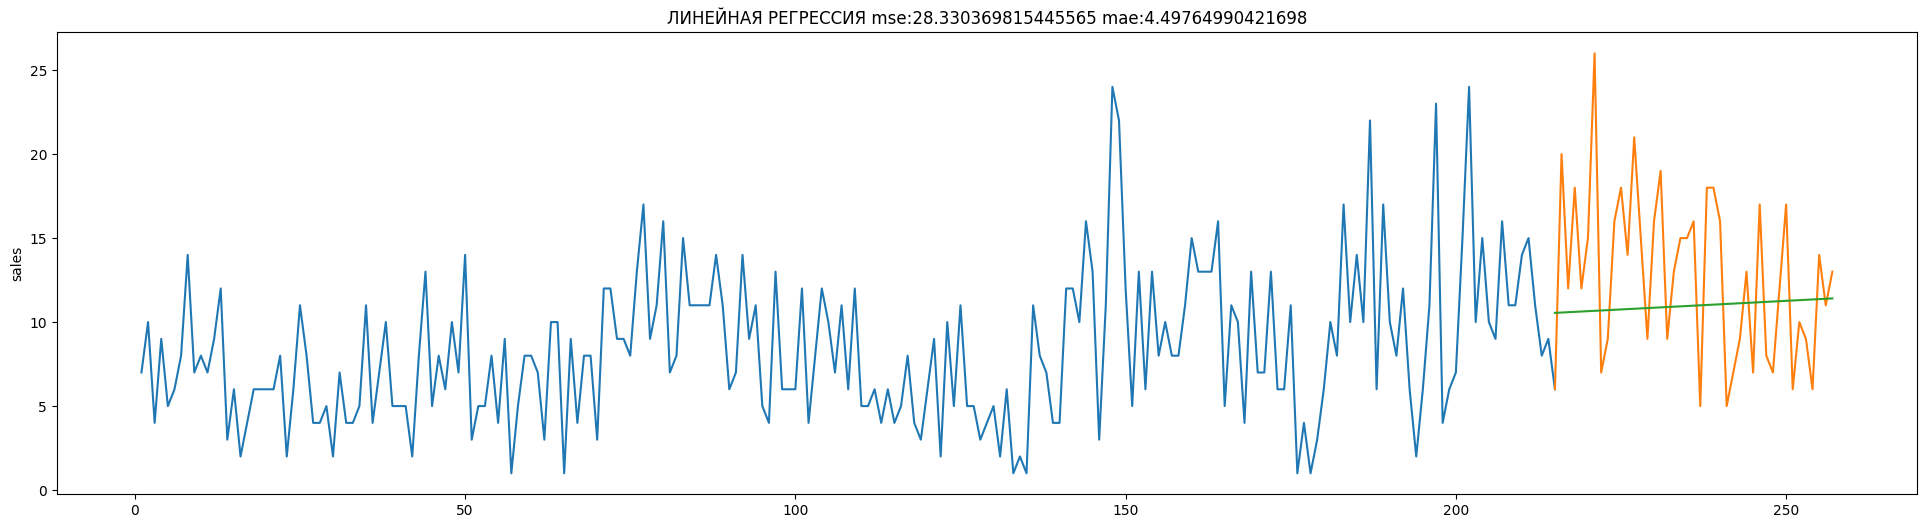

In [ ]:
mse_scores = []
mae_scores = []
for train_index, test_index in tscv.split(df_new):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    plt.figure(figsize=(24,6))
    sns.lineplot(df_new['sales'].iloc[train_index+1])
    sns.lineplot(df_new['sales'].iloc[test_index])
    sns.lineplot(x= test_index ,y = y_pred)
    plt.title(f'ЛИНЕЙНАЯ РЕГРЕССИЯ mse:{mse} mae:{mae}')
    plt.show()
    mse_scores.append(mse)
    mae_scores.append(mae)
line_mse = np.mean(mse_scores)
line_mae = np.mean(mae_scores)

In [ ]:
y_pred = model.predict(X)
mean_squared_error(y, y_pred)

19.498340018261278

### Полиномиальная регрессия

In [ ]:
X = pd.DataFrame(df_new.index)
y = df_new['sales']
X

,0
0,0
1,1
2,2
3,3
4,4
...,...
253,253
254,254
255,255
256,256


In [ ]:
mse_scores = []
best_params = {'mse':999, 'params':[]}
for p in range(0,10):
  for train_index, test_index in tscv.split(df_new):
      X_train = X.iloc[train_index]
      X_test = X.iloc[test_index]
      y_train = y.iloc[train_index]
      y_test = y.iloc[test_index]

      poly = PolynomialFeatures(degree=p)
      X_train_poly = poly.fit_transform(X_train)
      X_test_poly = poly.transform(X_test)

      model = LinearRegression()
      model.fit(X_train_poly, y_train)

      y_pred = model.predict(X_test_poly)
      mse = mean_squared_error(y_test, y_pred)
      mse_scores.append(mse)
  average_mse = np.mean(mse_scores)
  if average_mse < best_params['mse']:
    best_params['mse'] = average_mse
    best_params['params'] = p
print(best_params)

{'mse': 27.27603797848687, 'params': 0}


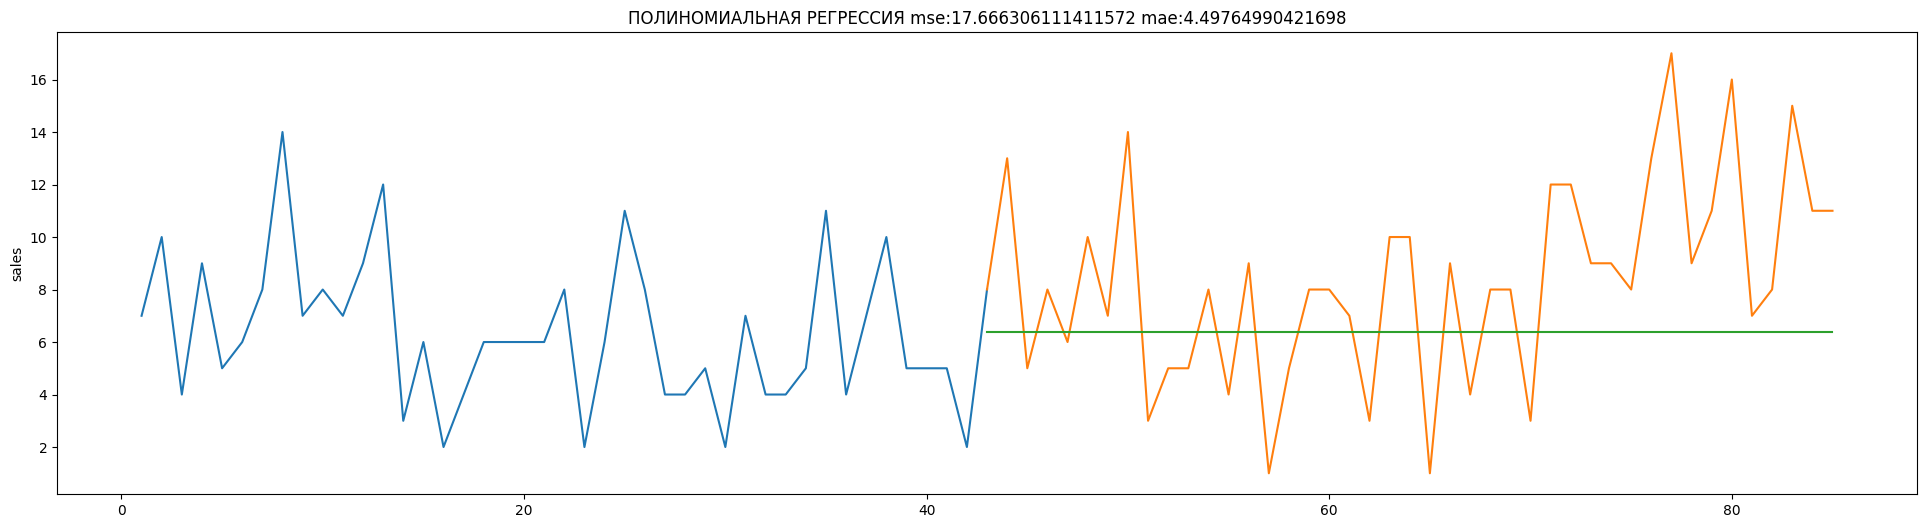

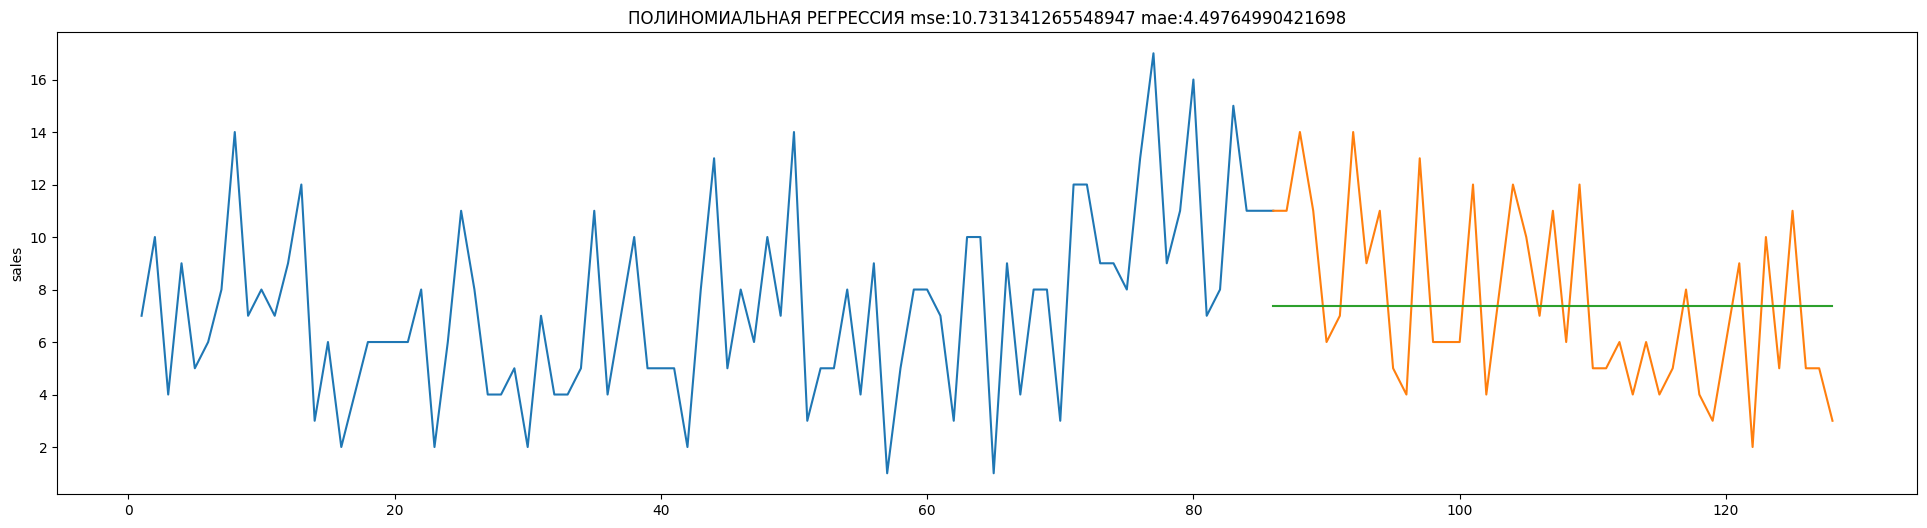

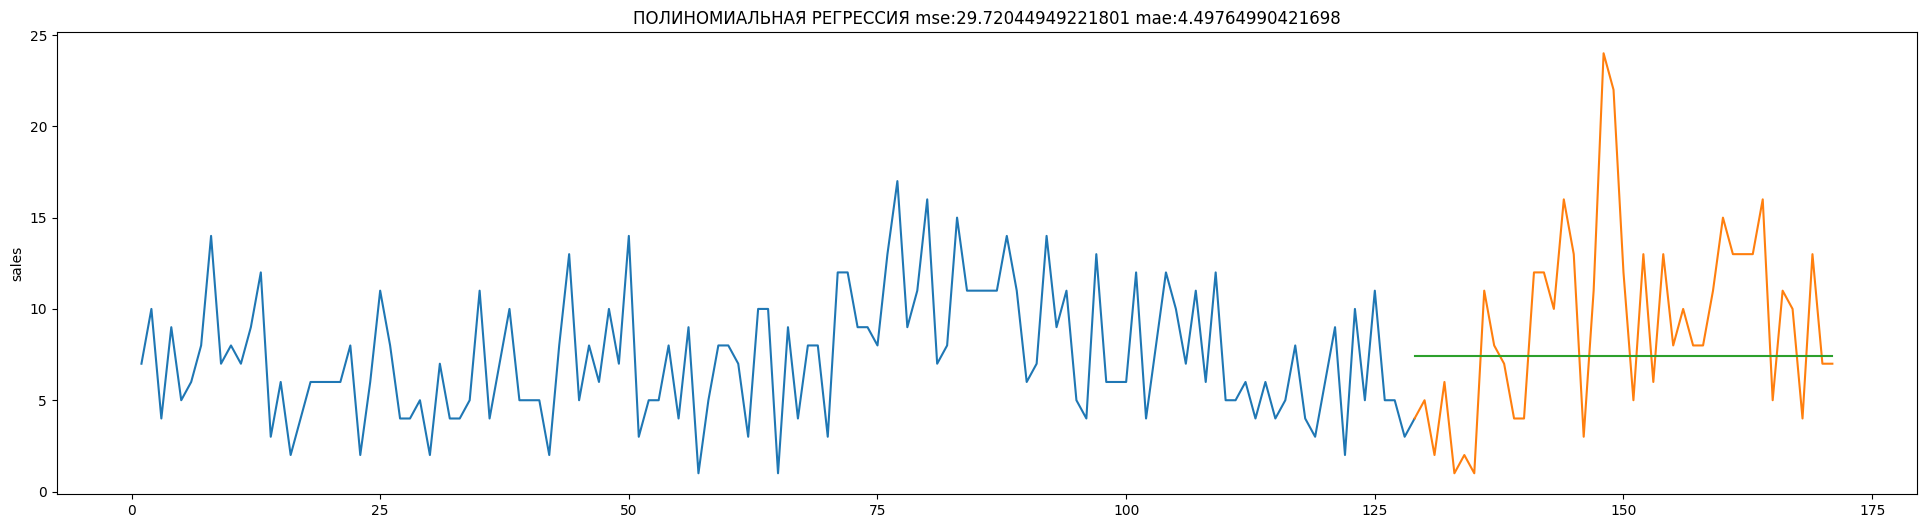

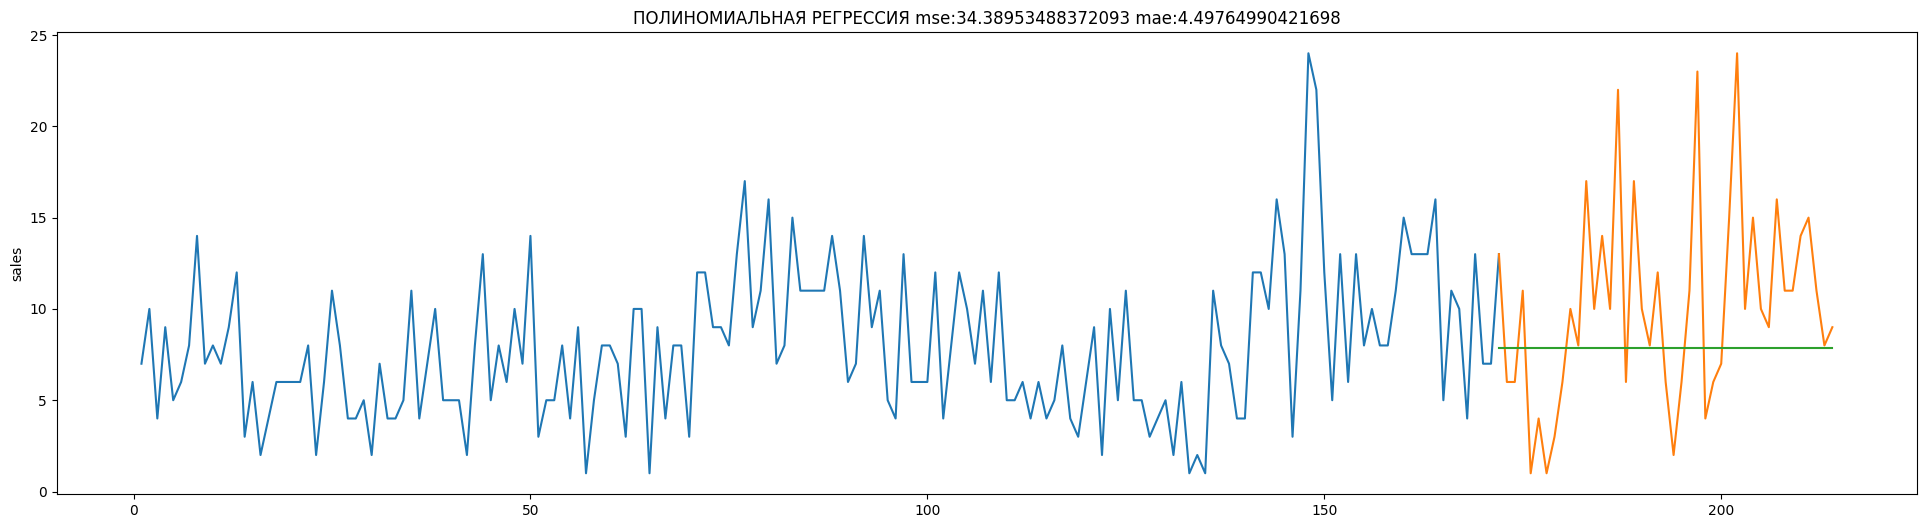

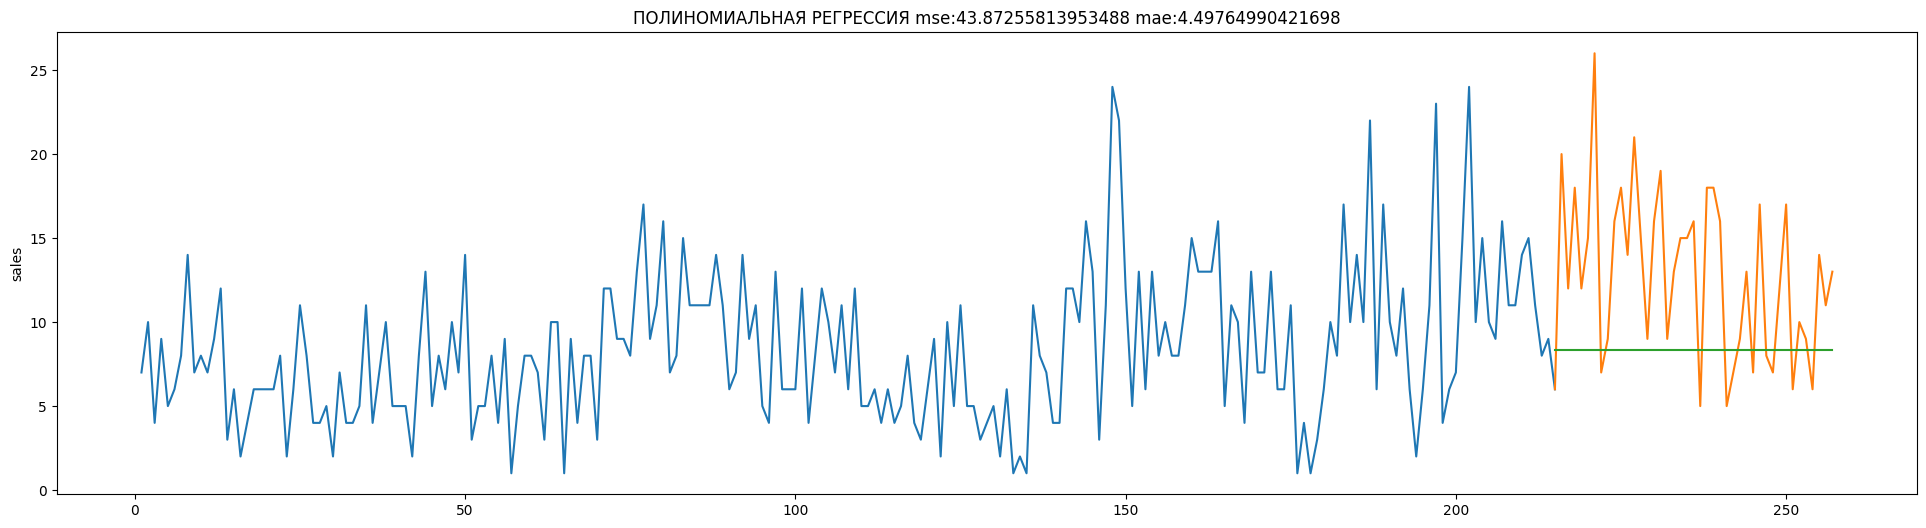

In [ ]:
mse_scores = []
best_params = {'mse':999, 'params':[]}
for train_index, test_index in tscv.split(df_new):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    poly = PolynomialFeatures(degree=0)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_pred = model.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)
    plt.figure(figsize=(24,6))
    sns.lineplot(df_new['sales'].iloc[train_index+1])
    sns.lineplot(df_new['sales'].iloc[test_index])
    sns.lineplot(x= test_index ,y = y_pred)
    plt.title(f'ПОЛИНОМИАЛЬНАЯ РЕГРЕССИЯ mse:{mse} mae:{mae}')
    plt.show()
    mse_scores.append(mse)
poly_mse = np.mean(mse_scores)
poly_mae = np.mean(mae_scores)

### ARIMA

In [ ]:
param_grid = {'p':range(0,5), 'd':range(0,3), 'q':range(0,3)}
best_params = {'mse':999, 'params':[]}
for p in param_grid['p']:
  for d in param_grid['d']:
    for q in param_grid['q']:
      mse_scores = []
      for train_index, test_index in tscv.split(df_new):
        train_data = df_new['sales'].iloc[train_index]
        test_data = df_new['sales'].iloc[test_index]
        model = ARIMA(train_data, order=(p, d, q))
        fitted_model = model.fit()

        predictions = fitted_model.forecast(len(test_data))

        mse = mean_squared_error(test_data, predictions)
        mse_scores.append(mse)

      average_mse = np.mean(mse_scores)
      if average_mse < best_params['mse']:
        best_params['mse'] = average_mse
        best_params['params'] = [p,d,q]
print(best_params)

{'mse': 25.9914652032082, 'params': [3, 0, 2]}


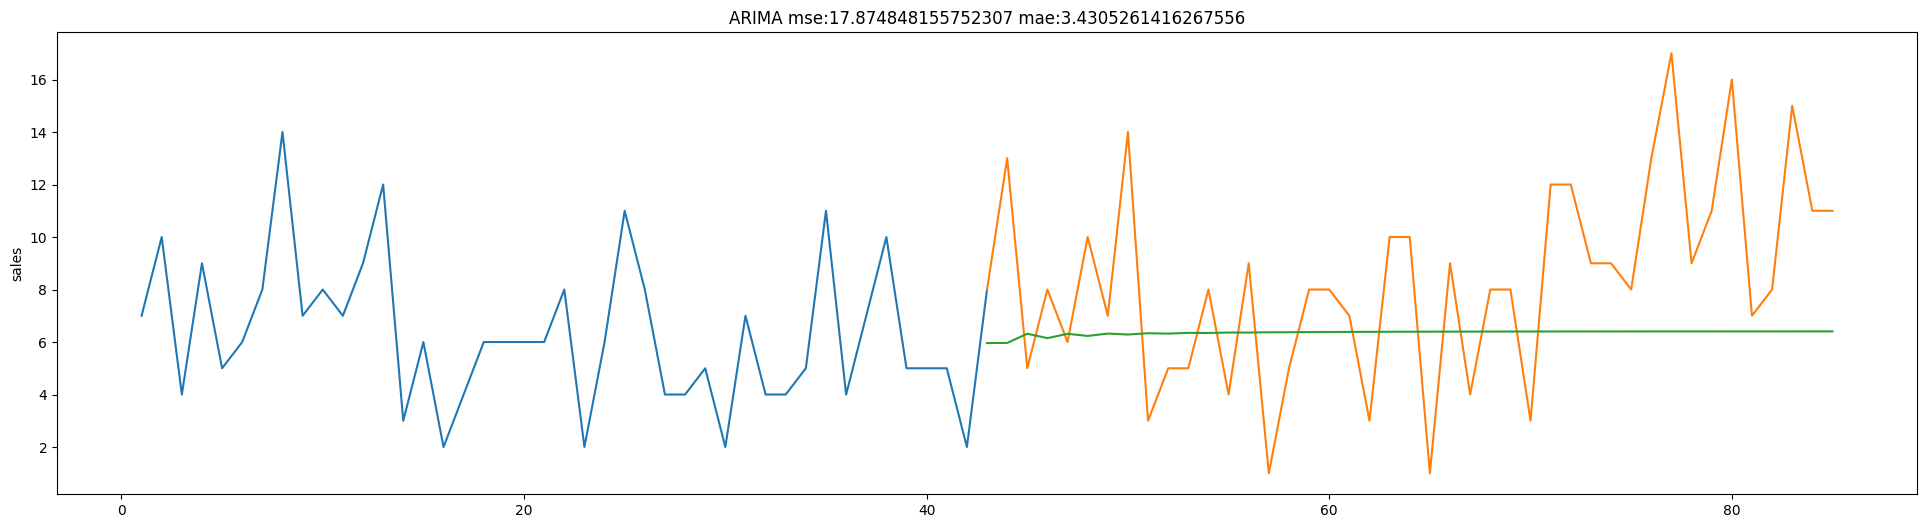

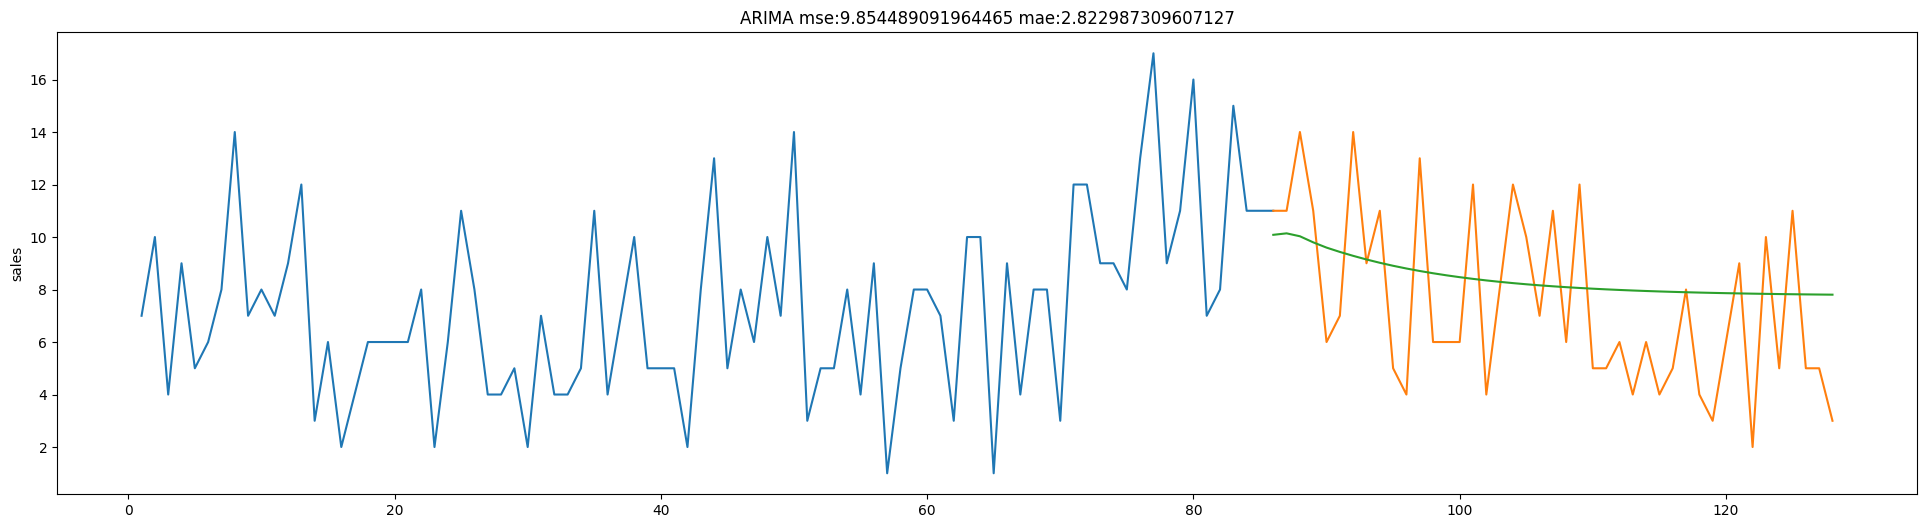

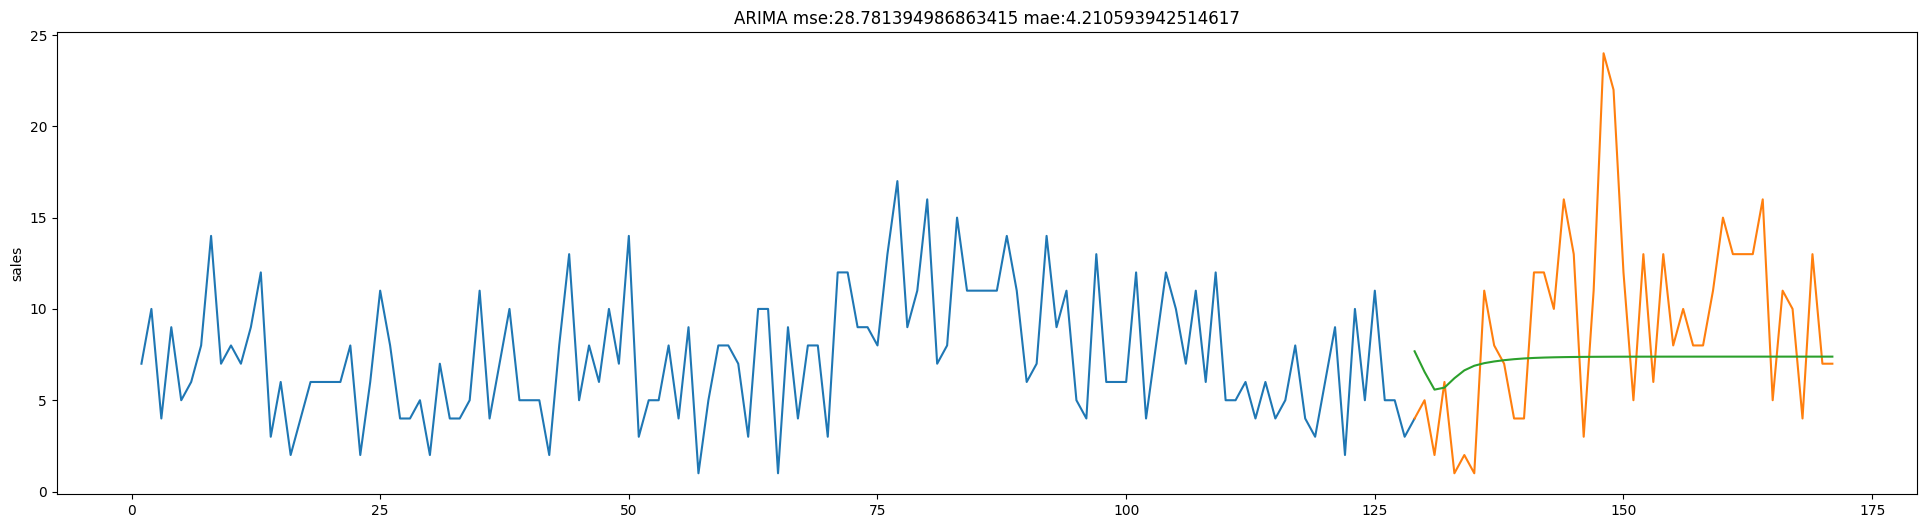

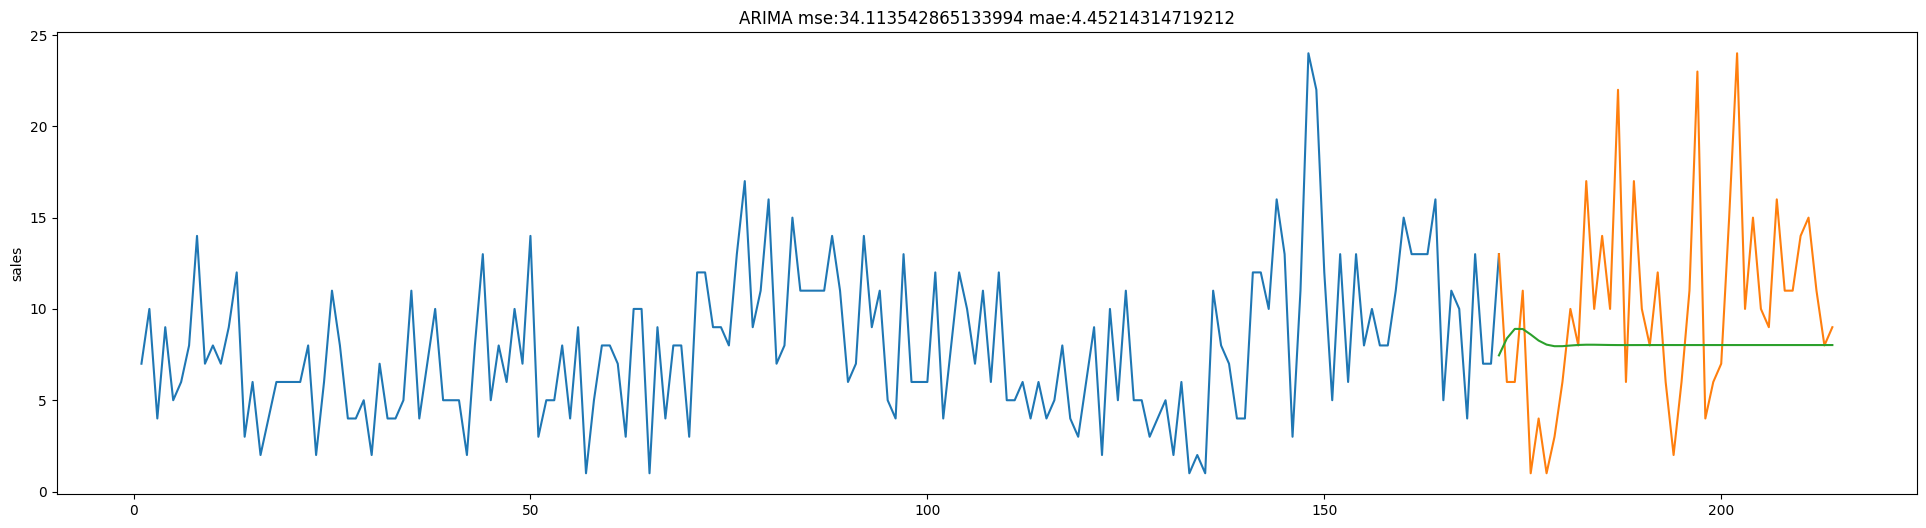

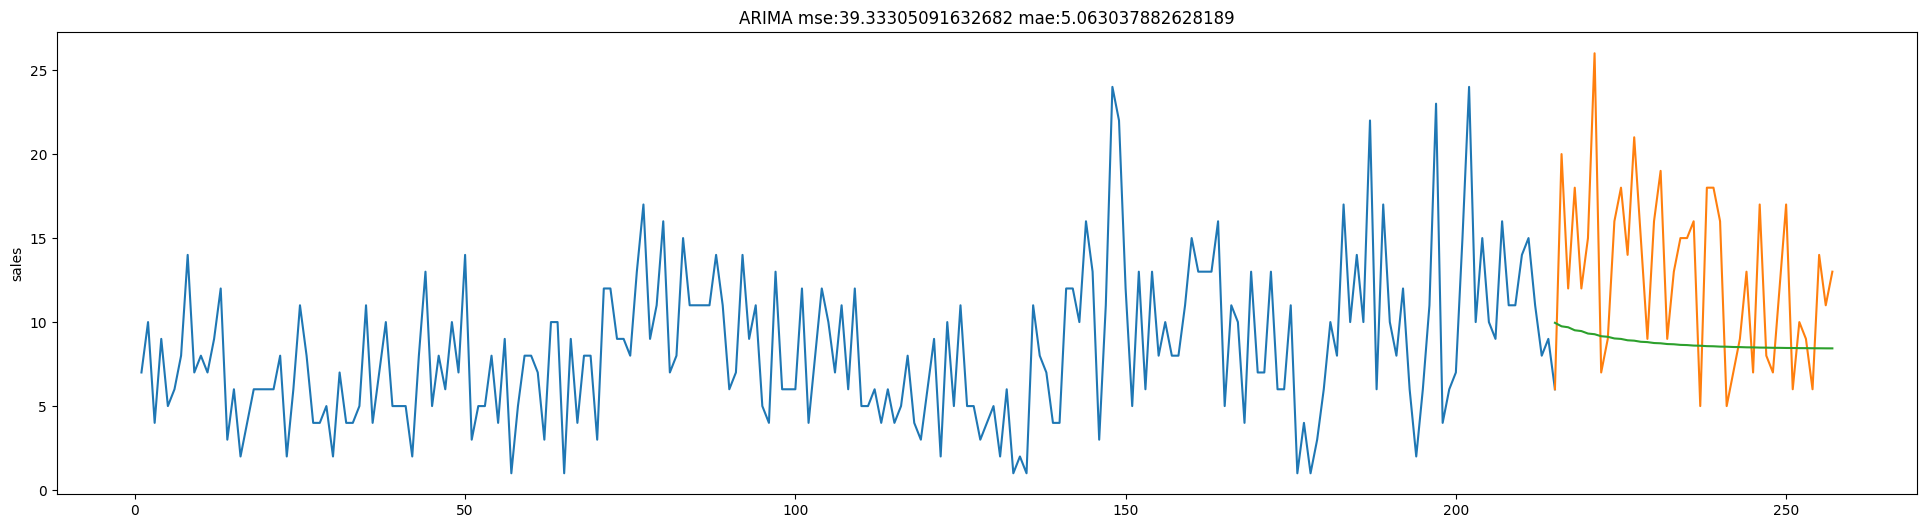

In [ ]:
mse_scores = []
mae_scores = []
for train_index, test_index in tscv.split(df_new):
    train_data = df_new['sales'].iloc[train_index]
    test_data = df_new['sales'].iloc[test_index]
    model = ARIMA(train_data, order=(best_params['params']))
    fitted_model = model.fit()

    predictions = fitted_model.forecast(len(test_data))
    mse = mean_squared_error(test_data, predictions)
    mae = mean_absolute_error(test_data, predictions)
    plt.figure(figsize=(24,6))
    sns.lineplot(df_new['sales'].iloc[train_index+1])
    sns.lineplot(test_data)
    sns.lineplot(predictions)
    plt.title(f'ARIMA mse:{mse} mae:{mae}')
    plt.show()
    mse_scores.append(mse)
    mae_scores.append(mae)
arima_mse = np.mean(mse_scores)
arima_mae = np.mean(mae_scores)

### SARIMAX

In [ ]:
df_new.head()

,date,sales
0,2024-03-01,11
1,2024-03-02,7
2,2024-03-03,10
3,2024-03-04,4
4,2024-03-05,9


In [ ]:
param_grid = {'p':range(0,5), 'd':range(0,3), 'q':range(0,3)}
best_params = {'mse':999, 'params':[]}
for p in param_grid['p']:
  for d in param_grid['d']:
    for q in param_grid['q']:
      mse_scores = []
      for train_index, test_index in tscv.split(df_new):
        train_data = df_new['sales'].iloc[train_index]
        test_data = df_new['sales'].iloc[test_index]
        model = SARIMAX(train_data, order=(p, d, q ))
        fitted_model = model.fit()

        predictions = fitted_model.forecast(len(test_data))

        mse = mean_squared_error(test_data, predictions)
        mse_scores.append(mse)

      average_mse = np.mean(mse_scores)
      if average_mse < best_params['mse']:
        best_params['mse'] = average_mse
        best_params['params'] = [p,d,q]
print(best_params)

{'mse': 27.767220762331057, 'params': [0, 1, 1]}


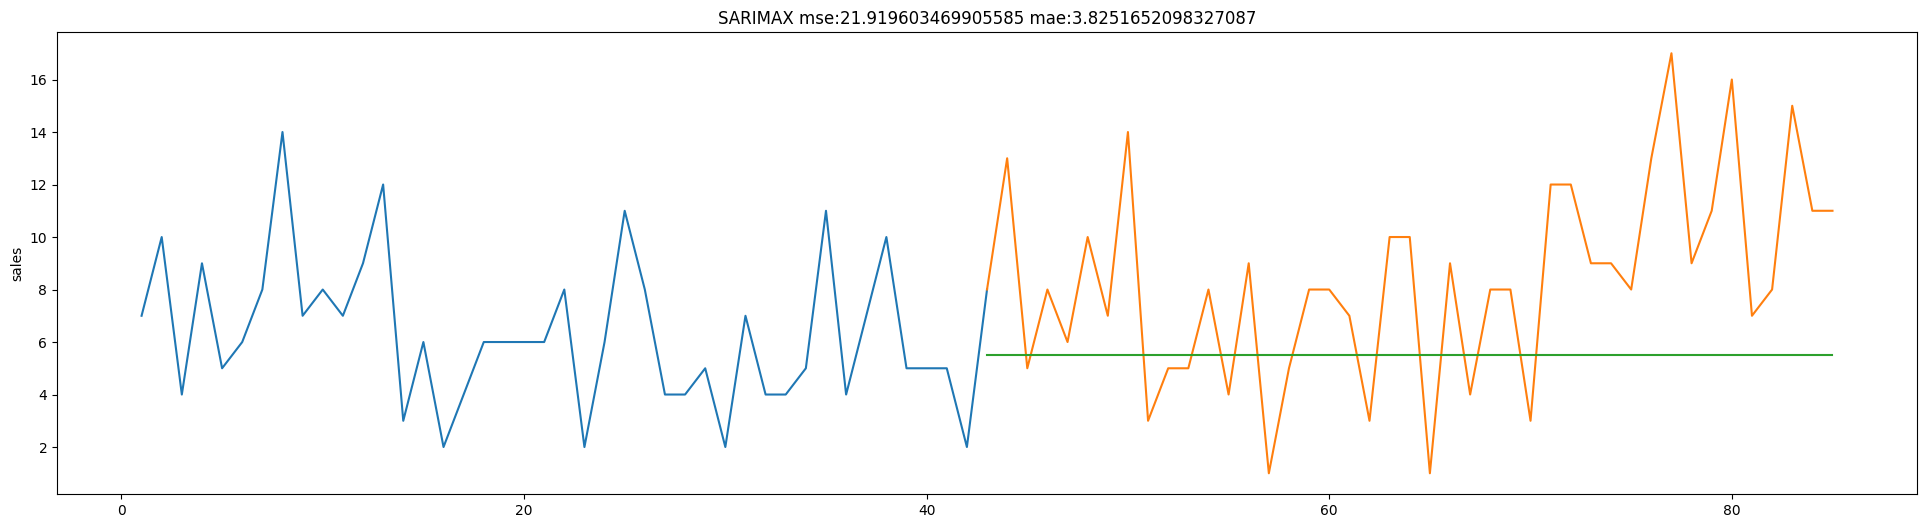

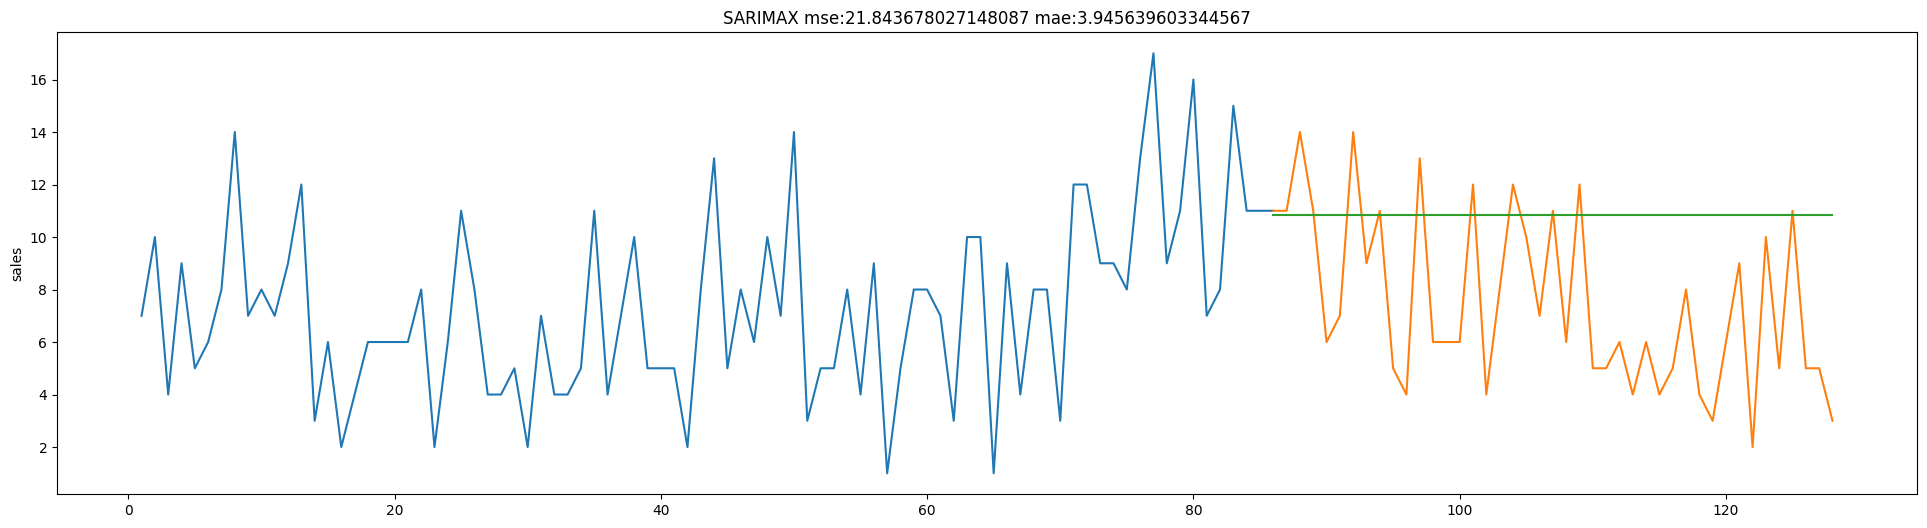

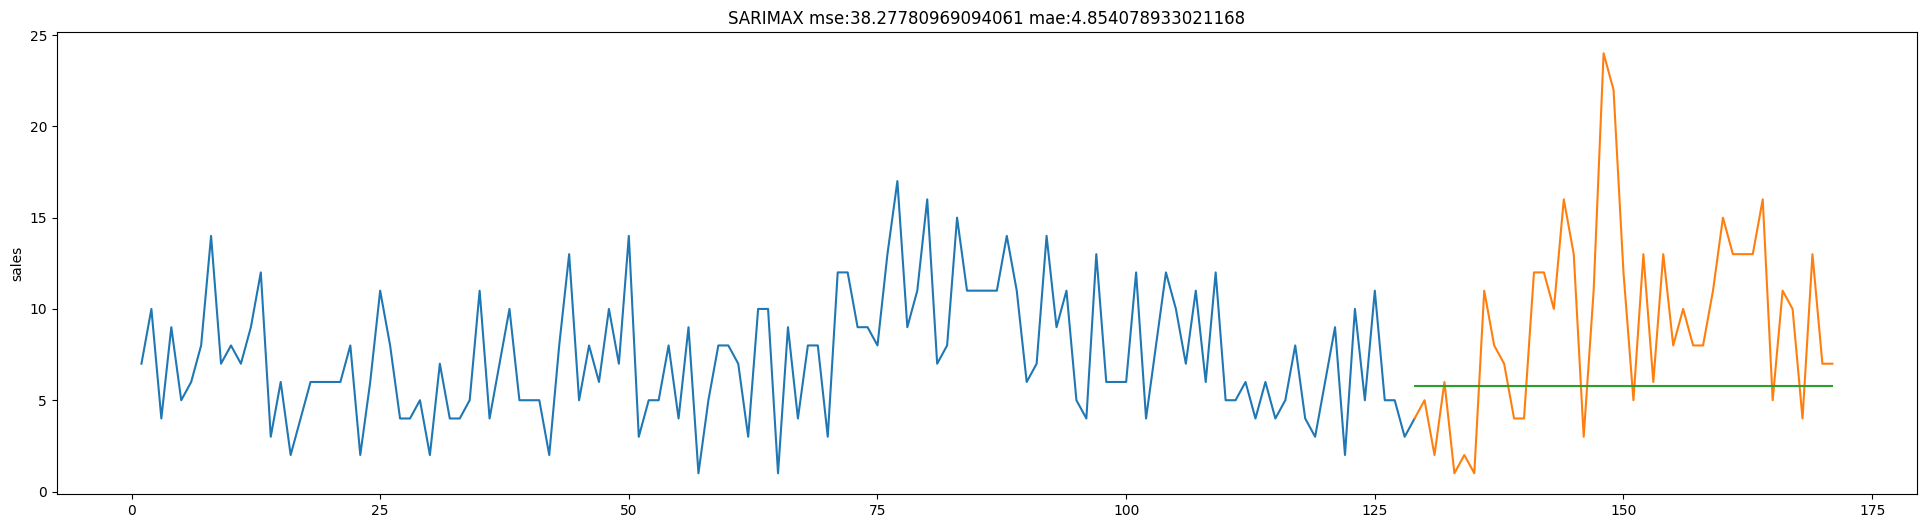

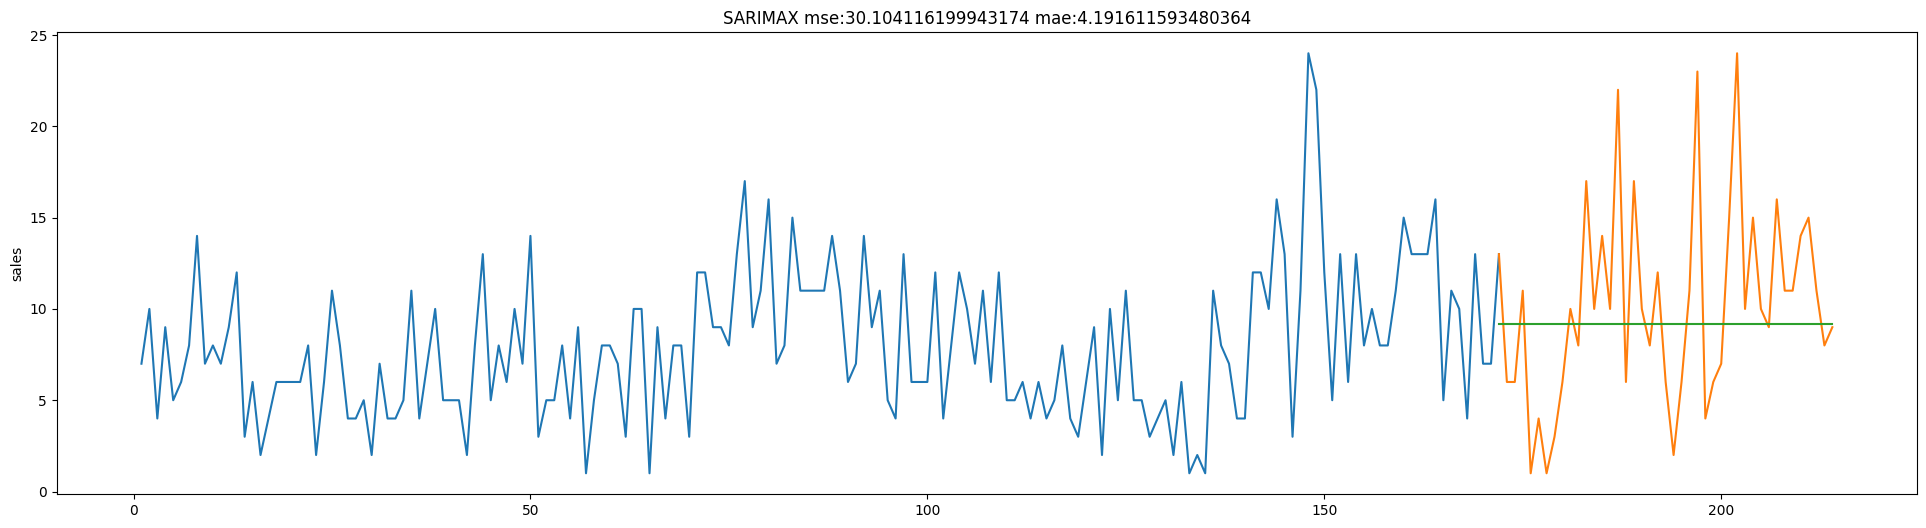

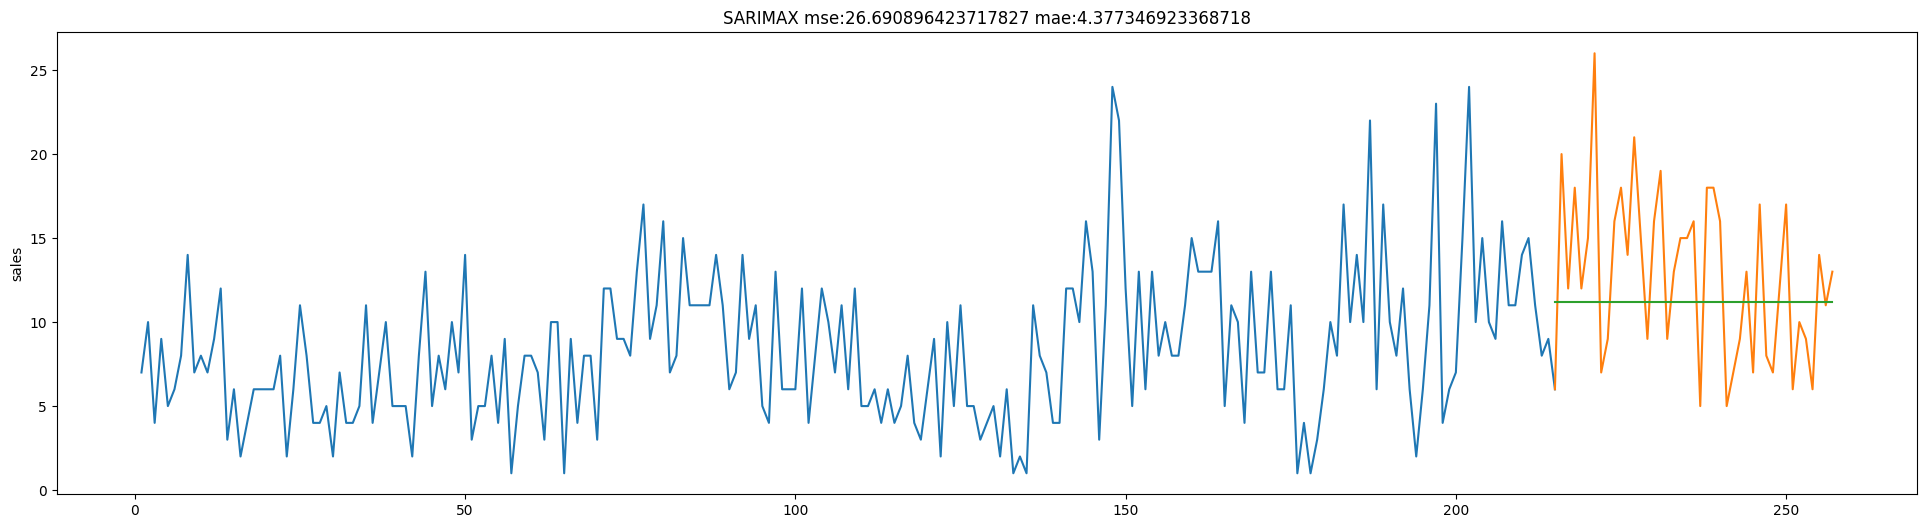

In [ ]:
mse_scores = []
mae_scores = []
for train_index, test_index in tscv.split(df_new):
    train_data = df_new['sales'].iloc[train_index]
    test_data = df_new['sales'].iloc[test_index]
    model = SARIMAX(train_data, order=(best_params['params']))
    fitted_model = model.fit()

    predictions = fitted_model.forecast(len(test_data))
    mse = mean_squared_error(test_data, predictions)
    mae = mean_absolute_error(test_data, predictions)
    plt.figure(figsize=(24,6))
    sns.lineplot(df_new['sales'].iloc[train_index+1])
    sns.lineplot(test_data)
    sns.lineplot(predictions)
    plt.title(f'SARIMAX mse:{mse} mae:{mae}')
    mse_scores.append(mse)
    mae_scores.append(mae)
sarimax_mse = np.mean(mse_scores)
sarimax_mae = np.mean(mae_scores)

## Сравнение моделей

In [ ]:
mae_mse = ['Линейная регрессия', line_mae, line_mse],['Полиномиальная регрессия', poly_mae, poly_mse],['ARIMA', arima_mae, arima_mse],['SARIMAX', sarimax_mae, sarimax_mse]
metrics = pd.DataFrame(mae_mse, columns=['model', 'MAE', 'MSE'])
print(metrics)

                      model       MAE        MSE
0        Линейная регрессия  4.399165  29.497612
1  Полиномиальная регрессия  4.399165  27.276038
2                     ARIMA  3.995858  25.991465
3                   SARIMAX  4.238768  27.767221


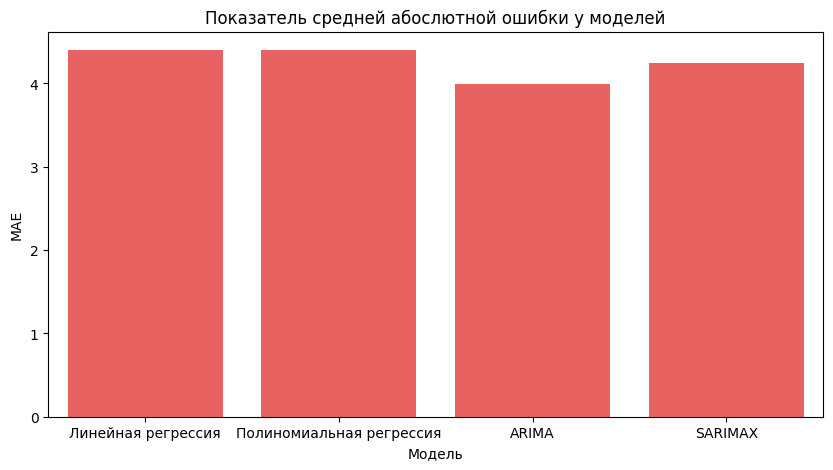

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(metrics, x='model', y='MAE', color='red', alpha=.7)
plt.title('Показатель средней абослютной ошибки у моделей')
plt.xlabel('Модель')

plt.show()

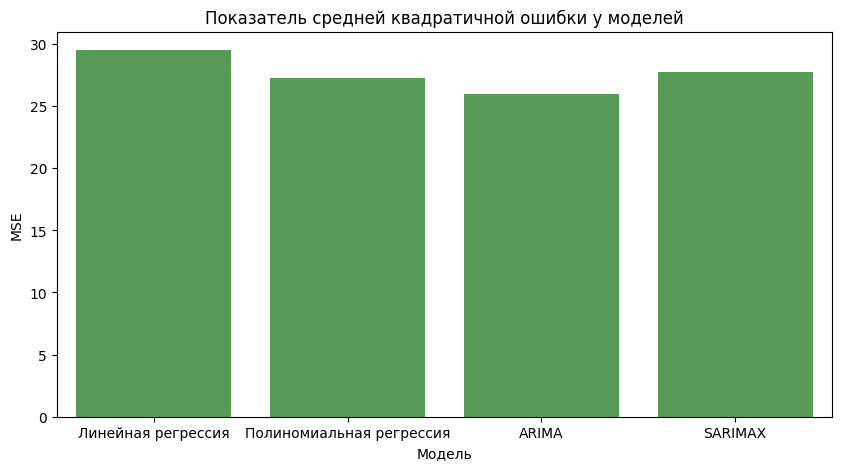

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(metrics, x='model', y='MSE', color='green', alpha=.7)
plt.title('Показатель средней квадратичной ошибки у моделей')
plt.xlabel('Модель')
plt.show()